In [1]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.models import Sequential

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os

In [2]:
!pip install imutils
from imutils import paths

2500 images (2940.00MB)
Data shape: (2500, 224, 224, 3)
Labels shape: (2500, 1)
Class labels:
1. Calling
2. Cheating
3. Climbing
4. Consuming
5. LisentingMusic
6. Sitting
7. Standing
8. Studying
9. Talking
10. Teaching


C:\Users\mouat\AppData\Local\Temp\ipykernel_13812\2184421754.py:41: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(include_top=False, input_tensor=Input(shape=input_shape))


[INFO] Training...
Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 497ms/step - accuracy: 0.1551 - loss: 3.6091 - val_accuracy: 0.3520 - val_loss: 2.0054
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 470ms/step - accuracy: 0.3132 - loss: 2.0277 - val_accuracy: 0.5140 - val_loss: 1.6037
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 463ms/step - accuracy: 0.4376 - loss: 1.7327 - val_accuracy: 0.7040 - val_loss: 1.0048
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 467ms/step - accuracy: 0.5814 - loss: 1.2556 - val_accuracy: 0.8480 - val_loss: 0.7379
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 487ms/step - accuracy: 0.6626 - loss: 0.9735 - val_accuracy: 0.9020 - val_loss: 0.3654
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 491ms/step - accuracy: 0.7629 - loss: 0.7242 - val_accuracy: 0.9120 - val_loss: 0.2980
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 470ms/step - accuracy: 0.8254 - loss: 0.5167 - val_accuracy: 0.9340 - val_loss: 0.2137
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 468ms/step - accuracy: 0.8766 - loss

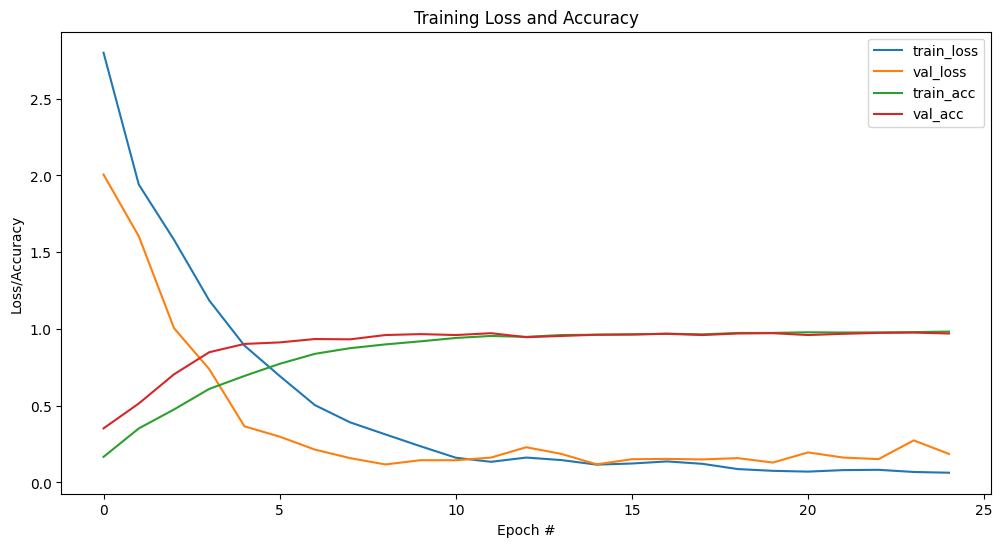

In [3]:
imagePaths = sorted(list(paths.list_images("E:/DATASET EXPERIMENT/Resize exp")))

# Randomly shuffle the image paths
random.seed(42)
random.shuffle(imagePaths)

# Initialize lists to store data and labels
data = []
labels = []
image_dims = (224, 224, 3)

# Load and preprocess the images
for image_path in imagePaths:
    image = cv2.imread(image_path)
    image = cv2.resize(image, (image_dims[1], image_dims[0]))
    image = img_to_array(image)
    data.append(image)
    label = image_path.split(os.path.sep)[-2].split("_")
    labels.append(label)

# Convert the data and labels to numpy arrays
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Print dataset information
print(f"{len(imagePaths)} images ({data.nbytes / (1024 * 1000.0):.2f}MB)")
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

# Initialize MultiLabelBinarizer and transform labels
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)

# Display class labels
print("Class labels:")
for i, label in enumerate(mlb.classes_):
    print(f"{i+1}. {label}")

# Define the MobileNetV2 model
def MobileNetV2_model(learning_rate, input_shape, class_number):
    baseModel = MobileNetV2(include_top=False, input_tensor=Input(shape=input_shape))
    for layer in baseModel.layers[:-4]:
        layer.trainable = False

    model = Sequential([
        baseModel,
        AveragePooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.5),
        Dense(50, activation="relu"),
        Dropout(0.5),
        Dense(class_number, activation='softmax')
    ])

    return model

# Set hyperparameters
lr = 0.0001
shape = (224, 224, 3)
class_number = len(mlb.classes_)
epochs = 25

# Create and compile the model
model = MobileNetV2_model(lr, shape, class_number)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

# Split the dataset into training and testing sets
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.20)

# Train the model
print("[INFO] Training...")
H = model.fit(trainX, trainY, batch_size=32, epochs=epochs, validation_data=(testX, testY))

# Plot the training history
plt.figure(figsize=(12, 6))
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [4]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=mlb.classes_))

[INFO] evaluating network...
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 413ms/step
                precision    recall  f1-score   support

       Calling       1.00      0.98      0.99        59
      Cheating       0.95      1.00      0.97        36
      Climbing       1.00      1.00      1.00        48
     Consuming       0.92      1.00      0.96        54
LisentingMusic       0.93      0.86      0.89        58
       Sitting       0.95      1.00      0.98        41
      Standing       0.96      0.94      0.95        48
      Studying       1.00      0.94      0.97        51
       Talking       1.00      1.00      1.00        52
      Teaching       1.00      1.00      1.00        53

      accuracy                           0.97       500
     macro avg       0.97      0.97      0.97       500
  weighted avg       0.97      0.97      0.97       500



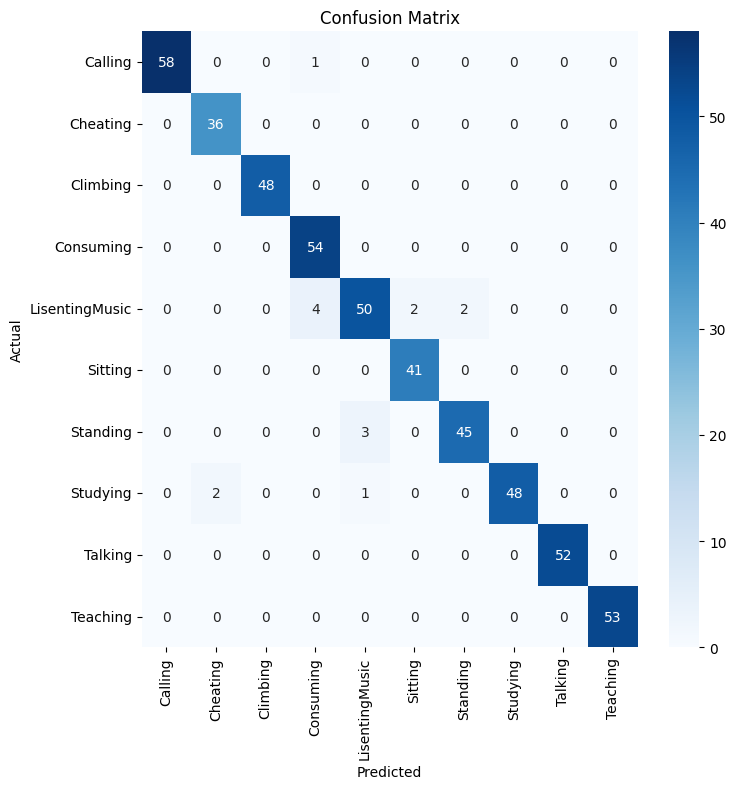

In [5]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(np.argmax(testY, axis=1), predIdxs)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


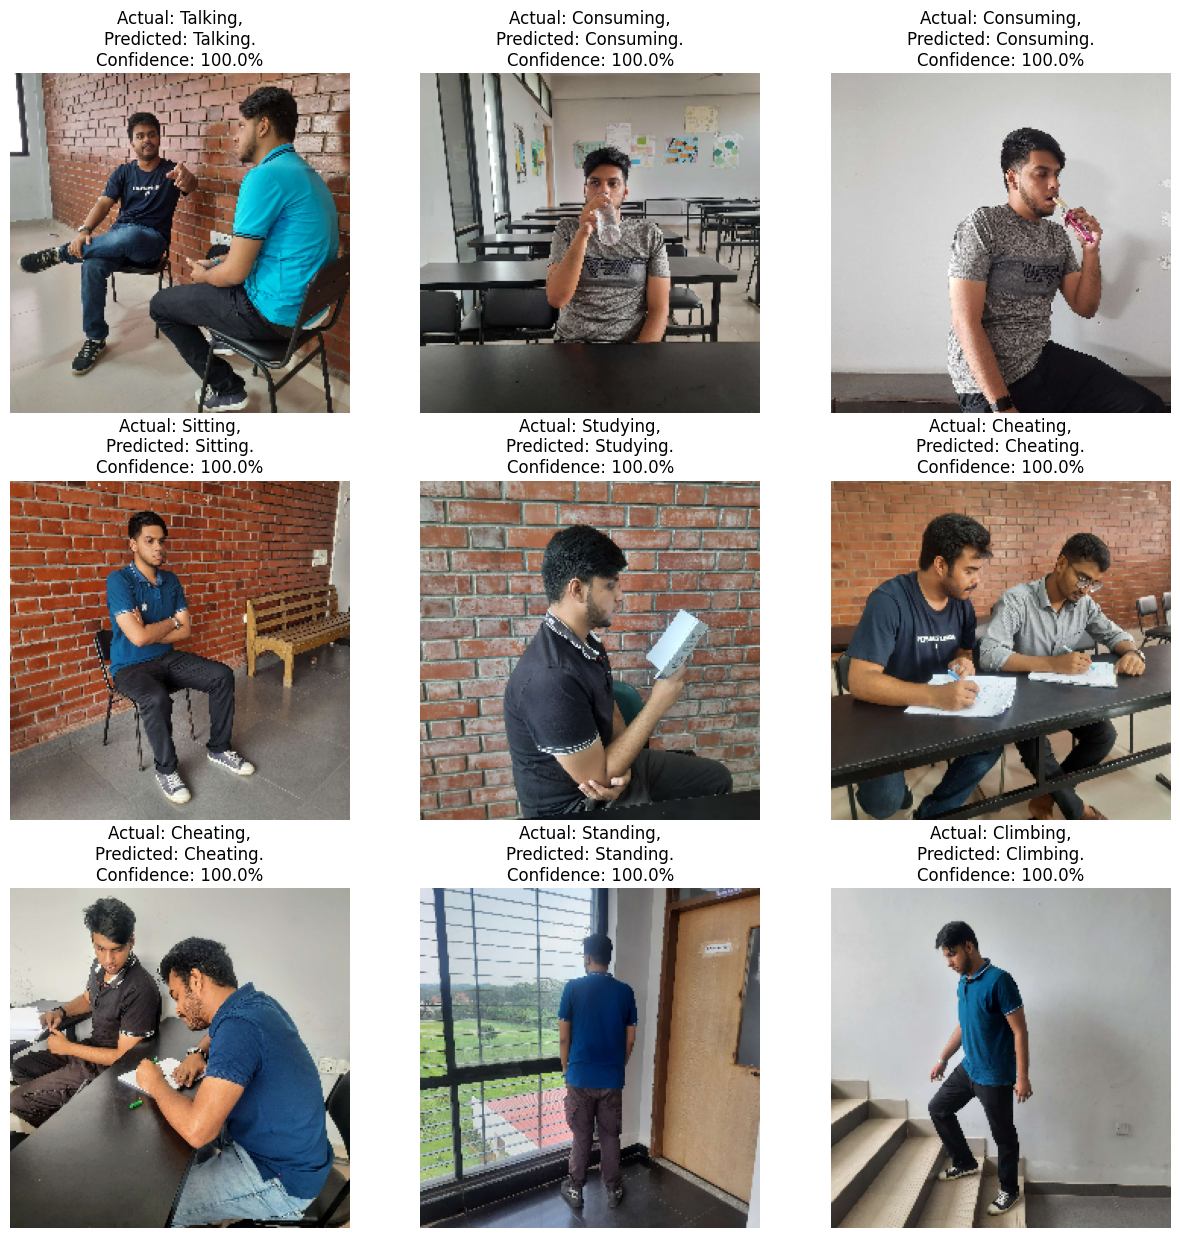

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array



# Define the predict function
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)  # Corrected line
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = mlb.classes_[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Visualize predictions
plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img_index = random.randint(0, len(testX) - 1)
    # Rescale pixel values to [0, 255] range
    img = (testX[img_index] * 255).astype(np.uint8)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    predicted_class, confidence = predict(model, testX[img_index])
    actual_class = mlb.classes_[np.argmax(testY[img_index])]
    plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence}%")
    plt.axis("off")
plt.show()



In [7]:
loss,test_accuracy = model.evaluate(testX, testY)
print('Accuracy on test:', test_accuracy)
print('Loss on test set:', loss)

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.9674 - loss: 0.1500
Accuracy on test: 0.9700000286102295
Loss on test set: 0.18531200289726257


In [11]:
from sklearn.model_selection import KFold

In [12]:
# Cross-validation setup
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

cv_train_accuracies = []
cv_val_accuracies = []
cv_train_losses = []
cv_val_losses = []

for fold, (train_index, test_index) in enumerate(kf.split(data)):
    print(f"Fold {fold+1}/{n_splits}")

    trainX, testX = data[train_index], data[test_index]
    trainY, testY = labels[train_index], labels[test_index]

    model = MobileNetV2_model(lr, shape, class_number)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

    H = model.fit(trainX, trainY, batch_size=32, epochs=epochs, validation_data=(testX, testY), verbose=0)

    cv_train_accuracies.append(H.history["accuracy"])
    cv_val_accuracies.append(H.history["val_accuracy"])
    cv_train_losses.append(H.history["loss"])
    cv_val_losses.append(H.history["val_loss"])

    print(f"Accuracy on fold {fold+1}: {H.history['val_accuracy'][-1]}")
    print(f"Loss on fold {fold+1}: {H.history['val_loss'][-1]}")

Fold 1/5


C:\Users\mouat\AppData\Local\Temp\ipykernel_13812\2184421754.py:41: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(include_top=False, input_tensor=Input(shape=input_shape))


Accuracy on fold 1: 0.9779999852180481
Loss on fold 1: 0.043731700628995895
Fold 2/5
Accuracy on fold 2: 0.9819999933242798
Loss on fold 2: 0.11675118654966354
Fold 3/5
Accuracy on fold 3: 0.9739999771118164
Loss on fold 3: 0.1585369110107422
Fold 4/5
Accuracy on fold 4: 0.9380000233650208
Loss on fold 4: 0.3976200819015503
Fold 5/5
Accuracy on fold 5: 0.9620000123977661
Loss on fold 5: 0.30160000920295715


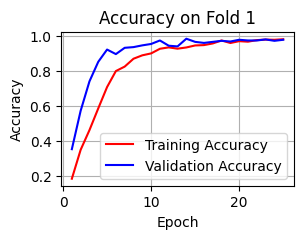

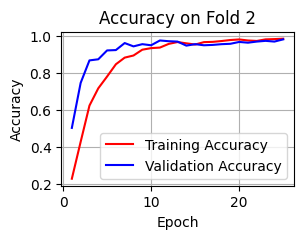

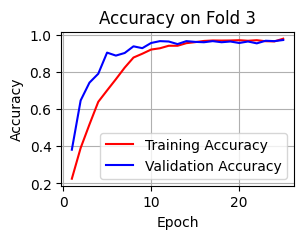

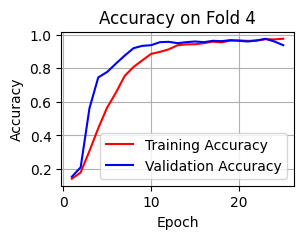

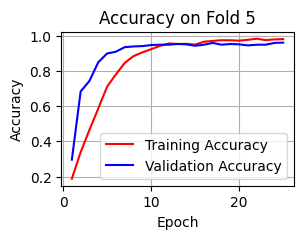

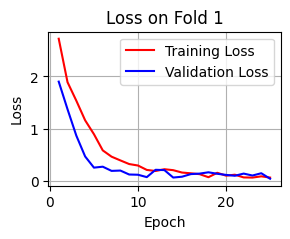

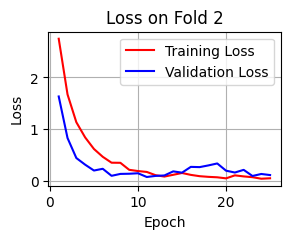

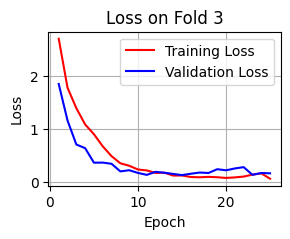

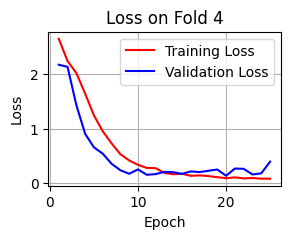

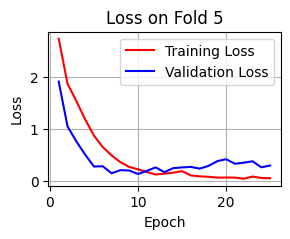


Mean cross-validation accuracy: 0.9667999982833863
Mean cross-validation loss: 0.2036479778587818


In [14]:
import matplotlib.pyplot as plt
# Plot accuracy for each fold
for fold in range(n_splits):
    plt.figure(figsize=(3, 2))
    epochs_range = range(1, epochs + 1)
    plt.plot(epochs_range, cv_train_accuracies[fold], 'r', label="Training Accuracy")
    plt.plot(epochs_range, cv_val_accuracies[fold], 'b', label="Validation Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy on Fold {fold+1}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Plot loss for each fold
for fold in range(n_splits):
    plt.figure(figsize=(3, 2))
    epochs_range = range(1, epochs + 1)
    plt.plot(epochs_range, cv_train_losses[fold], 'r', label="Training Loss")
    plt.plot(epochs_range, cv_val_losses[fold], 'b', label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss on Fold {fold+1}')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Summary of cross-validation results
mean_cv_accuracy = np.mean([acc[-1] for acc in cv_val_accuracies])
mean_cv_loss = np.mean([loss[-1] for loss in cv_val_losses])
print(f"\nMean cross-validation accuracy: {mean_cv_accuracy}")
print(f"Mean cross-validation loss: {mean_cv_loss}")